In [1]:
# get permission to access drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


1. Take your best-performing logistic regression model from Problem Set 1 (or train a new one). Use `cross_val_predict()` to form model predictions for each observation. Construct a confusion matrix for the predictions. Report the `precision_recall_curve()` and `roc_curve()`. Make a calibration plot (as in Bansak et al. 2018, appendix page 24).

In [2]:
# The following has been copied from problem set 1
import pandas as pd
import numpy as np
datapath = '/content/gdrive/My Drive/Colab Notebooks/data/'
cases = pd.read_csv(datapath + 'case_metadata.csv')
cases = cases.dropna(subset=['log_cites'])
no_of_cases = 1000
random_indices = list(np.random.choice(cases.shape[0], no_of_cases, replace = False))
caseids = list(cases.iloc[random_indices]["caseid"])

In [3]:
# load the cases
import glob

text = {}
casepath = datapath + 'cases/'
for caseid in caseids:
    names = glob.glob(casepath + "*_" + caseid + ".txt")  # try to find file with particular caseid
    if len(names) > 0:  # if file exists
      filename = names[0]
      file = open(filename, mode = 'r')
      case = filename[len(casepath):-len('.txt')]  # keep year_caseid
      text[case] = file.read()
      file.close()


In [4]:
import spacy
nlp = spacy.load('en', disable=['ner'])
docs = {}
for case in text:
    docs[case] = nlp(text[case])

In [5]:
words = {}
for case in docs:
    words[case] = [token for token in docs[case] if token.is_alpha]

In [6]:
# save part of speech tags for later
pos = {str(word).lower(): word.pos_ for word in words[case] for case in words}

In [7]:
from string import punctuation
translator = str.maketrans('', '', punctuation) 

##################################################
# - we do not remove stopwords, since otherwise the trigrams are less meaningful
# - we do not stem the words, since this might change the part of speech tag (in that case, we cannot correctly find trigrams ending in a noun)
##################################################
def normalize_text(doc):
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ')
        lower = sent.lower()  # all lower case
        nopunc = lower.translate(translator)  # remove punctuation
        words = nopunc.split()  # split into tokens
        no_numbers = [w if not w.isdigit() else '#' for w in words]  # normalize numbers
        tokens += no_numbers  # add to list of tokens for this speech
    return tokens

In [8]:
normalized = {}
for case in docs:
    normalized[case] = normalize_text(docs[case])

In [9]:
# make a feature set of all trigrams that end in a noun
import nltk
from nltk import trigrams
ends_in_noun = {}
for case in normalized:
    trigrams = list(nltk.trigrams(normalized[case]))
    ends_in_noun[case] = []
    for trigram in trigrams:
        string = " ".join(trigram)
        if trigram[2] in pos and pos[trigram[2]] == 'NOUN':
            ends_in_noun[case].append(string)

In [10]:
from collections import Counter
frequencies = {}
for case in ends_in_noun:
    to_count = (trigram for trigram in ends_in_noun[case])
    frequencies[case] = Counter(to_count).most_common()

In [11]:
# features: the trigrams that are contained in all documents, plus the top-K most common ones in any of the documents
import math
features = set()
no_of_most_common_trigrams = math.ceil(1000 / no_of_cases)  # this is the K we choose for top-K
intersection = set(map(lambda x: x[0], list(frequencies.values())[0]))  # initially contains all trigrams of arbitrary document
for case in frequencies:
    for trigram in set(map(lambda x: x[0], frequencies[case][0:min(no_of_most_common_trigrams, len(frequencies[case]))])):
        features.add(trigram)
    intersection = intersection.intersection(set(map(lambda x: x[0], frequencies[case])))
features = list(features.union(intersection))

In [12]:
df = pd.DataFrame(columns = ["case"] + features)
for case in frequencies:
    data = {}
    data["case"] = case[5:len(case)]  # now keeping only case id and throwing away year
    for feature in features:
        if feature in dict(frequencies[case]):
            data[feature] = dict(frequencies[case])[feature]
        else:
            data[feature] = 0
    df = df.append(data, ignore_index = True)

for feature in features:
    df[feature] /= np.sqrt(np.var(df[feature]))  # standardize to variance 1

In [13]:
df = df.join(pd.read_csv(datapath + 'case_metadata.csv').set_index('caseid'), on='case')

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
X_log = df.loc[:, features]
y_log = df.case_reversed

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

grid = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(), grid, cv = 10)             
grid_search.fit(X_log, y_log)

logreg = LogisticRegression(penalty = grid_search.best_params_['penalty'], C = grid_search.best_params_['C'])

predictions = cross_val_predict(logreg, X_log, y_log, cv = 10)
probabilities = cross_val_predict(logreg, X_log, y_log, cv = 10, method = 'predict_proba')[:, 0]

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_log, predictions)

array([[ 48, 329],
       [ 43, 579]])

In [17]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_log, probabilities)

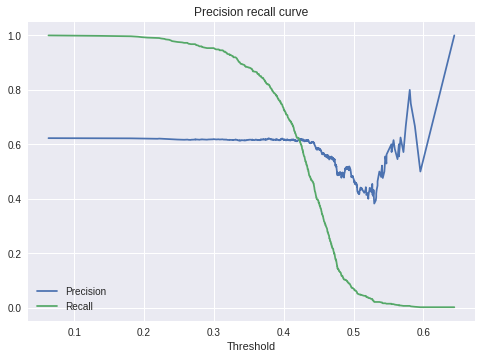

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.title('Precision recall curve')
plt.plot(thresholds, precisions[:-1], label = 'Precision')
plt.plot(thresholds, recalls[:-1], label = 'Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_log, probabilities)

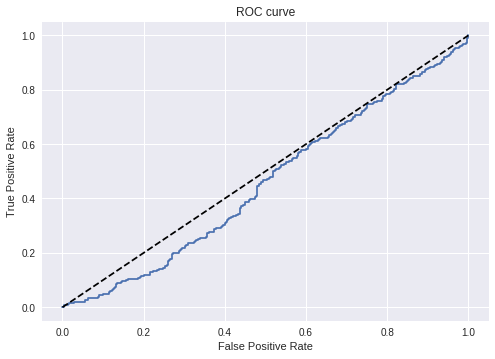

In [20]:
plt.figure()
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [21]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
logreg_y, logreg_x = calibration_curve(y_log, probabilities, n_bins=20)

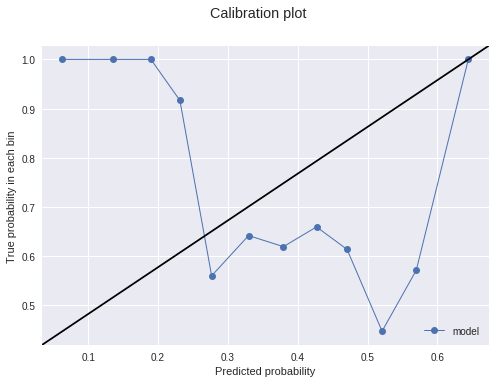

In [22]:
fig, ax = plt.subplots()
plt.plot(logreg_x, logreg_y, marker='o', linewidth=1, label='model')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

2. Scale your n-gram frequencies while maintaining sparsity, as discussed in class. Train an elastic net model to predict log citations to a case (**log_cites**). Run `cross_val_predict()` to form model predictions and report a scatter plot of true and predicted values. 


In [23]:
from sklearn.linear_model import ElasticNet
for feature in features:
  if np.var(df[feature]) > 0:
    df[feature] /= np.sqrt(np.var(df[feature]))  # standardize to variance 1

X = df.loc[:, features]
Y = df.log_cites

grid = {'alpha': np.logspace(-3, 3, 7), 'l1_ratio': np.linspace(0.1, 0.9, 5)}
grid_search = GridSearchCV(ElasticNet(), grid, cv = 10)             
grid_search.fit(X, Y)

Y_pred = cross_val_predict(ElasticNet(alpha = grid_search.best_params_['alpha'], l1_ratio = grid_search.best_params_['l1_ratio']), X, Y, cv = 10)

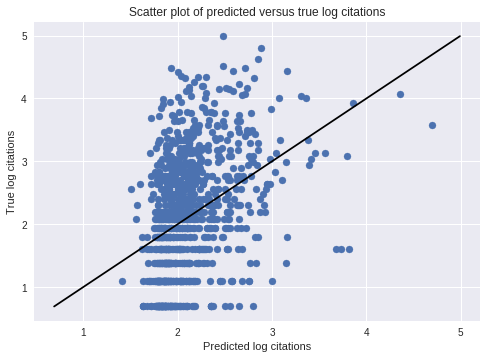

In [24]:
plt.figure()
plt.scatter(Y_pred, Y)
smallest = min(min(Y_pred), min(Y))
largest = max(max(Y_pred), max(Y))
plt.plot([smallest, largest], [smallest, largest], color='black')
plt.xlabel('Predicted log citations')
plt.ylabel('True log citations')
plt.title('Scatter plot of predicted versus true log citations')
plt.show()

3. Use the judge identifiers (**judge_id**) to produce the average citations to cases for each judge. Then estimate a two-stage least-squares model with Z as average citations of the judge, X as citations to the case, and Y as whether the case was reversed. Include **year** fixed effects. Report estimates for coefficient and standard error on X. 

In [25]:
df['citations'] = np.exp(df['log_cites'])
ids = df['judge_id']
Z = df[['judge_id', 'citations']].groupby(['judge_id']).mean().lookup(ids, ['citations'] * len(ids)).reshape((len(ids), 1))
X = df['citations'].reshape((len(ids), 1))
Y = df['case_reversed'].reshape((len(ids), 1))
year = df['year'].reshape((len(ids), 1))

In [26]:
import statsmodels.api as sm
Z = sm.add_constant(Z)
X_hat = sm.OLS(X, Z).fit().predict(Z).reshape((len(ids), 1))
X_hat_new = np.concatenate((X_hat, year), axis = 1)  # include year fixed effects
X_hat_new = sm.add_constant(X_hat_new)
linreg = sm.OLS(Y, X_hat_new)
print("Coefficients (intercept is first element): ")
print(linreg.fit().params)
print("Standard error: (in same order)")
print(linreg.fit().bse)

Coefficients (intercept is first element): 
[-4.82552745e+00 -3.58176704e-03  2.78904732e-03]
Standard error (in same order): 
[1.37710183e+00 1.38041782e-03 7.01881428e-04]


4. Train LDA on the cases. Produce word clouds for the topics. Inspect the word clouds for different models to decide on the right number of topics.

In [27]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
stoplist.update(['#', 'united', 'states', 'us', 'court', 'case', 'v', 'federal', 'district', 'state', 'would'])  # remove uninformative words (chosen after inspection of word clouds)

for case in normalized:
  normalized[case] = [word for word in normalized[case] if word not in stoplist]  # remove stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# creating the term dictionary
from gensim import corpora
documents = [normalized[case] for case in normalized]
dictionary = corpora.Dictionary(documents)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in documents]

# train LDA with 8 topics and print (number of topics chosen after inspection of word clouds)
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics = 8, id2word = dictionary, passes = 10)
lda.show_topics(formatted=False)

[(0,
  [('sct', 0.007833126),
   ('act', 0.0072977617),
   ('section', 0.0069558145),
   ('see', 0.0048789587),
   ('may', 0.0040226756),
   ('congress', 0.003927429),
   ('usc', 0.003688876),
   ('f2d', 0.0033951793),
   ('government', 0.003354397),
   ('courts', 0.0032709418)]),
 (1,
  [('sct', 0.008588064),
   ('see', 0.005793461),
   ('law', 0.004558336),
   ('courts', 0.004514968),
   ('id', 0.0043068263),
   ('led2d', 0.0042544478),
   ('claim', 0.004234616),
   ('f2d', 0.0037994466),
   ('usc', 0.0037511932),
   ('may', 0.0034095745)]),
 (2,
  [('sct', 0.009695727),
   ('evidence', 0.0055375802),
   ('see', 0.005306259),
   ('led2d', 0.004538078),
   ('law', 0.0044817394),
   ('jury', 0.0043704477),
   ('id', 0.0041631036),
   ('trial', 0.0040002936),
   ('whether', 0.0035854047),
   ('also', 0.0033486502)]),
 (3,
  [('sct', 0.00680775),
   ('school', 0.0059045306),
   ('f2d', 0.0044898633),
   ('schools', 0.0040153298),
   ('led2d', 0.0036752694),
   ('board', 0.0036118813),
  

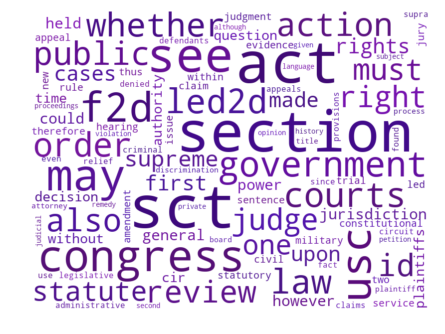

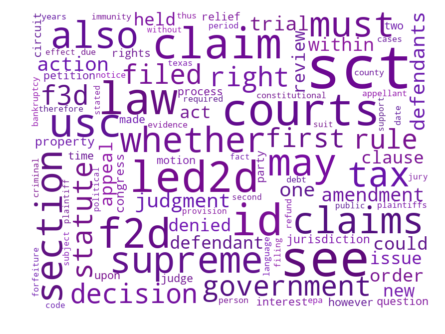

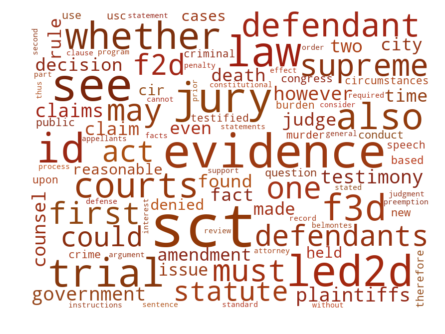

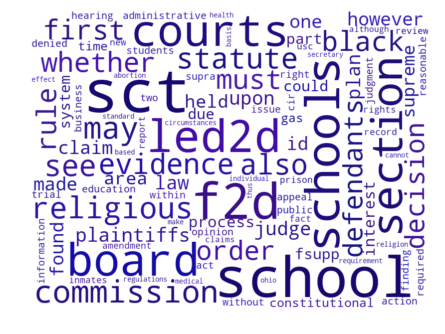

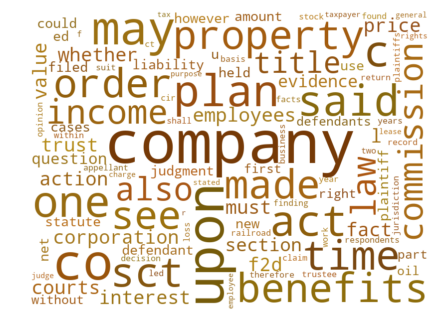

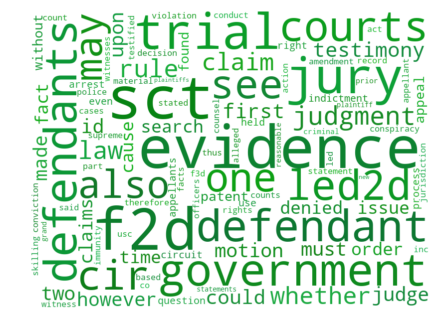

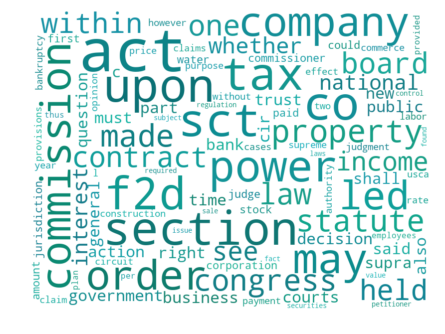

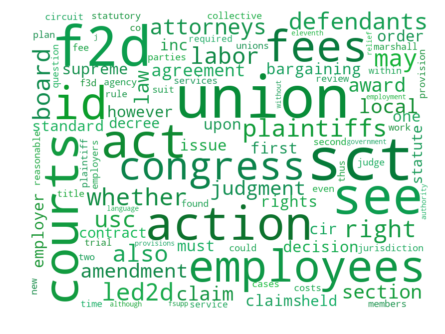

In [29]:
from wordcloud import WordCloud

# make word clouds for the topics
for i, weights in lda.show_topics(num_topics=-1,
                                  num_words=100,
                                  formatted=False):
    
    maincol = np.random.randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = np.random.randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color, np.random.randint(65, 75)+font_size / 7, np.random.randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600, width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


5. Replicate your sklearn logistic regression model (no hidden layers, L2 regularization, and softmax output layer) in Keras or some other deep learning library. Compare performance. Now add two hidden layers, dropout, and batch normalization. Compare performance.

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

X_deep = np.array(X_log)
y_deep = np.array(y_log)

model = Sequential()
model.add(Dense(2, activation = 'softmax', kernel_regularizer = l2(0.01), input_dim = X_deep.shape[1]))
model.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_deep, y_deep, epochs = 5, validation_split = 0.1)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 899 samples, validate on 100 samples
Epoch 1/5
899/899 [==============================] - 1s 767us/step - loss: 0.9802 - acc: 0.5573 - val_loss: 1.0646 - val_acc: 0.4900
Epoch 2/5
899/899 [==============================] - 0s 120us/step - loss: 0.8678 - acc: 0.6062 - val_loss: 1.0407 - val_acc: 0.5700
Epoch 3/5
899/899 [==============================] - 0s 132us/step - loss: 0.7859 - acc: 0.6285 - val_loss: 1.0195 - val_acc: 0.5500
Epoch 4/5
899/899 [==============================] - 0s 133us/step - loss: 0.7201 - acc: 0.6529 - val_loss: 0.9974 - val_acc: 0.5700
Epoch 5/5
899/899 [==============================] - 0s 120us/step - loss: 0.6657 - acc: 0.6719 - val_loss: 0.9798 - val_acc: 0.5700


In [31]:
pred_deep = model.predict(X_deep)[:, 1]  # take the probability of class 1 (note that we do not lose information since the probabilities of both classes add up to 1)

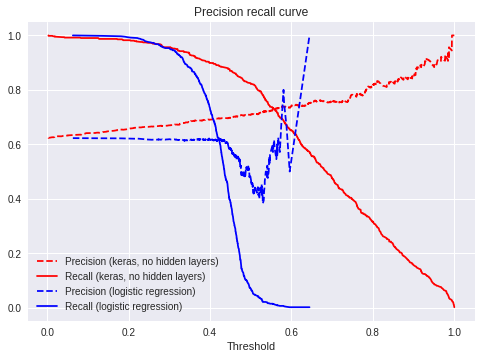

In [32]:
precisions_d, recalls_d, thresholds_d = precision_recall_curve(y_deep, pred_deep)
plt.figure()
plt.title('Precision recall curve')
plt.plot(thresholds_d, precisions_d[:-1], color = 'red', ls = '--', label = 'Precision (keras, no hidden layers)')
plt.plot(thresholds_d, recalls_d[:-1], color = 'red', label = 'Recall (keras, no hidden layers)')
plt.plot(thresholds, precisions[:-1], color = 'blue', ls = '--', label = 'Precision (logistic regression)')
plt.plot(thresholds, recalls[:-1], color = 'blue', label = 'Recall (logistic regression)')
plt.xlabel('Threshold')
plt.legend()
plt.show()

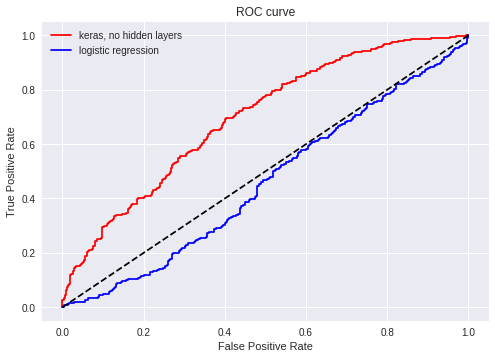

In [33]:
fpr_d, tpr_d, _ = roc_curve(y_deep, pred_deep)
plt.figure()
plt.title('ROC curve')
plt.plot(fpr_d, tpr_d, color = 'red', label = 'keras, no hidden layers')
plt.plot(fpr, tpr, color = 'blue', label = 'logistic regression')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

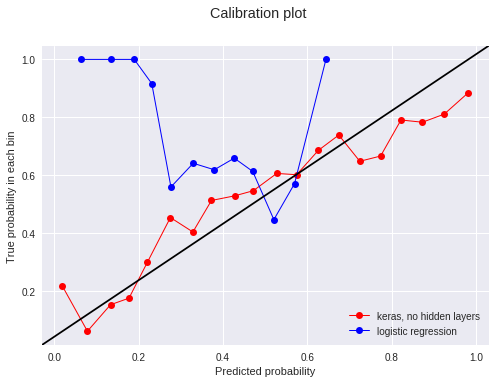

In [34]:
dl_y, dl_x = calibration_curve(y_deep, pred_deep, n_bins=20)
fig, ax = plt.subplots()
plt.plot(dl_x, dl_y, marker='o', linewidth=1, color = 'red', label='keras, no hidden layers')
plt.plot(logreg_x, logreg_y, marker='o', linewidth=1, color = 'blue', label='logistic regression')
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

In [35]:
from keras.layers import BatchNormalization, Dropout, Activation

model2 = Sequential()
model2.add(Dense(32, input_dim = X_deep.shape[1]))
model2.add(BatchNormalization())
model2.add(Activation('tanh'))
model2.add(Dropout(rate = 0.5))

model2.add(Dense(16))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(rate = 0.5))

model2.add(Dense(2, kernel_regularizer = l2(0.01)))
model2.add(BatchNormalization())
model2.add(Activation('softmax'))
model2.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model2.fit(X_deep, y_deep, epochs = 10, validation_split = 0.1)

Train on 899 samples, validate on 100 samples
Epoch 1/10
899/899 [==============================] - 1s 1ms/step - loss: 0.9364 - acc: 0.5362 - val_loss: 0.7188 - val_acc: 0.5600
Epoch 2/10
899/899 [==============================] - 0s 184us/step - loss: 0.8851 - acc: 0.5373 - val_loss: 0.7171 - val_acc: 0.5700
Epoch 3/10
899/899 [==============================] - 0s 186us/step - loss: 0.8593 - acc: 0.5495 - val_loss: 0.7130 - val_acc: 0.5700
Epoch 4/10
899/899 [==============================] - 0s 215us/step - loss: 0.8476 - acc: 0.5595 - val_loss: 0.7106 - val_acc: 0.5800
Epoch 5/10
899/899 [==============================] - 0s 204us/step - loss: 0.8201 - acc: 0.5406 - val_loss: 0.7087 - val_acc: 0.6000
Epoch 6/10
899/899 [==============================] - 0s 214us/step - loss: 0.7620 - acc: 0.5818 - val_loss: 0.7066 - val_acc: 0.6300
Epoch 7/10
899/899 [==============================] - 0s 218us/step - loss: 0.7540 - acc: 0.5873 - val_loss: 0.7070 - val_acc: 0.6100
Epoch 8/10
899/899

In [36]:
pred_deep2 = model2.predict(X_deep)[:, 1]

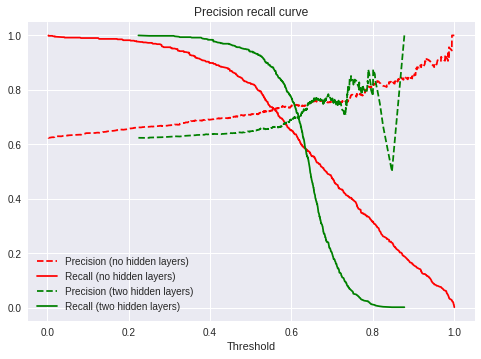

In [37]:
precisions_d2, recalls_d2, thresholds_d2 = precision_recall_curve(y_deep, pred_deep2)
plt.figure()
plt.title('Precision recall curve')
plt.plot(thresholds_d, precisions_d[:-1], color = 'red', ls = '--', label = 'Precision (no hidden layers)')
plt.plot(thresholds_d, recalls_d[:-1], color = 'red', label = 'Recall (no hidden layers)')
plt.plot(thresholds_d2, precisions_d2[:-1], color = 'green', ls = '--', label = 'Precision (two hidden layers)')
plt.plot(thresholds_d2, recalls_d2[:-1], color = 'green', label = 'Recall (two hidden layers)')
plt.xlabel('Threshold')
plt.legend()
plt.show()

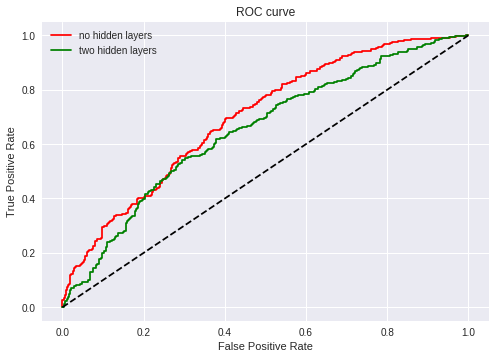

In [38]:
fpr_d2, tpr_d2, _ = roc_curve(y_deep, pred_deep2)
plt.figure()
plt.title('ROC curve')
plt.plot(fpr_d, tpr_d, color = 'red', label = 'no hidden layers')
plt.plot(fpr_d2, tpr_d2, color = 'green', label = 'two hidden layers')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

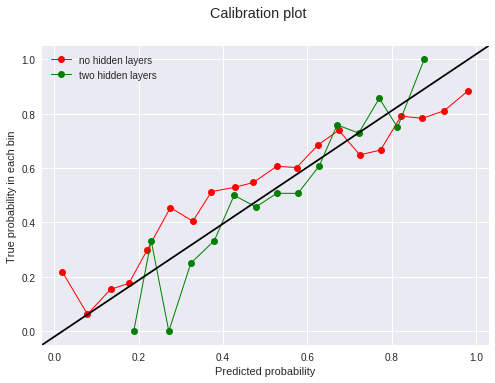

In [39]:
dl2_y, dl2_x = calibration_curve(y_deep, pred_deep2, n_bins=20)
fig, ax = plt.subplots()
plt.plot(dl_x, dl_y, marker='o', linewidth=1, color = 'red', label='no hidden layers')
plt.plot(dl2_x, dl2_y, marker='o', linewidth=1, color = 'green', label='two hidden layers')
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()